# 1. 데이터 준비

In [1]:
import pandas as pd

train_df = pd.read_csv('train.csv', nrows=2000)
train_df

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1000009418151094273,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,10000169349117863715,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,10000371904215119486,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,10000640724480838376,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,10000679056417042096,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,10285851261435514187,0,14102100,1005,0,97c9ac6a,5baa6f69,f66779e6,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157
1996,10285895913379867992,0,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,d44c074c,ae637522,...,1,2,21611,320,50,2480,3,297,100111,61
1997,10286262651832627320,0,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,53de0284,d9b5648e,...,1,0,21611,320,50,2480,3,297,100111,61
1998,1028628829893990987,0,14102100,1002,0,85f751fd,c4e18dd6,50e219e0,c73fb408,7801e8d9,...,0,0,17894,320,50,2039,2,39,100077,32


In [2]:
unused_columns = ['id','hour','device_id','device_ip']
label_column = 'click'

train_df = train_df.drop(unused_columns, axis=1)
X_dict_train = list(train_df.drop(label_column, axis=1).T.to_dict().values())
y_train = train_df[label_column]

In [3]:
test_df = pd.read_csv('train.csv', skiprows=(1,2000), nrows=2000)
test_df = test_df.drop(unused_columns, axis=1)
X_dict_test = list(test_df.drop(label_column, axis=1).T.to_dict().values())
y_test = test_df[label_column]

In [4]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer(sparse=True)
X_train = vectorizer.fit_transform(X_dict_train)
print(X_train.shape)

X_test = vectorizer.transform(X_dict_test)
print(X_test.shape)

(2000, 992)
(2000, 992)


# 2-1. 모델 학습(DecisionTree)

In [5]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(criterion='gini', random_state=156)
decision_tree.fit(X_train, y_train)
decision_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 156,
 'splitter': 'best'}

In [6]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth': [3,5,7,10], 'min_samples_split':[10,30,50]}
grid_search = GridSearchCV(decision_tree, parameters, n_jobs=-1, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
decision_tree_best = grid_search.best_estimator_

{'max_depth': 7, 'min_samples_split': 50}


In [7]:
import numpy as np
y_pred = decision_tree_best.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import roc_auc_score, roc_curve
y_pred_proba = decision_tree_best.predict_proba(X_test)[:,1] # 클릭할 확률만 추출

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

0.849
[[1643   27]
 [ 275   55]]


# 2-2. 모델 학습(RandomForest)

In [8]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(criterion='gini', random_state=156)
random_forest.fit(X_train, y_train)
random_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 156,
 'verbose': 0,
 'warm_start': False}

In [9]:
parameters = {'max_depth': [3,5,7,10], 'min_samples_split':[10,30,50], 'n_estimators':[100,200,500]}
grid_search = GridSearchCV(random_forest, parameters, n_jobs=-1, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
random_forest_best = grid_search.best_estimator_

{'max_depth': 10, 'min_samples_split': 50, 'n_estimators': 100}


In [10]:
y_pred = random_forest_best.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

y_pred_proba = random_forest_best.predict_proba(X_test)[:,1]
fpr2, tpr2, _ = roc_curve(y_test, y_pred_proba)
auc2 = roc_auc_score(y_test, y_pred_proba)

0.835
[[1670    0]
 [ 330    0]]


# 2-3. 모델 학습(LogisticRegression)

In [11]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)
clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [12]:
parameters = {'C':[0.001,0.01,0.1,1.0,10], 'penalty':['l1','l2'], 'random_state':[156]}
grid_search = GridSearchCV(clf, parameters, n_jobs=-1, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
clf_best = grid_search.best_estimator_

{'C': 1.0, 'penalty': 'l2', 'random_state': 156}


C:\Users\711\anaconda3\envs\study\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.6203432         nan 0.62038668        nan 0.62007074
        nan 0.62076192        nan 0.62033187]
  category=UserWarning


In [13]:
y_pred = clf_best.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

y_pred_proba = clf_best.predict_proba(X_test)[:,1]
fpr3, tpr3, _ = roc_curve(y_test, y_pred_proba)
auc3 = roc_auc_score(y_test, y_pred_proba)

0.8335
[[1666    4]
 [ 329    1]]


# 2-4. 모델 학습(KNN)

In [14]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [15]:
parameters = {'n_neighbors':[1,2,3,4,5]}
grid_search = GridSearchCV(knn, parameters, n_jobs=-1, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
knn_best = grid_search.best_estimator_

{'n_neighbors': 3}


In [16]:
y_pred = knn_best.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
y_pred_proba = knn_best.predict_proba(X_test)[:,1] # 클릭할 확률만 추출

fpr4, tpr4, _ = roc_curve(y_test, y_pred_proba)
auc4 = roc_auc_score(y_test, y_pred_proba)

0.8645
[[1614   56]
 [ 215  115]]


# 3. 최종

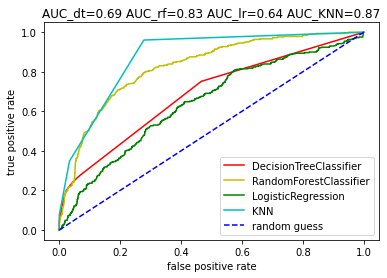

In [17]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, 'r-', label='DecisionTreeClassifier')
plt.plot(fpr2, tpr2, 'y-', label='RandomForestClassifier')
plt.plot(fpr3, tpr3, 'g-', label='LogisticRegression')
plt.plot(fpr4, tpr4, 'c-', label='KNN')
plt.plot([0,1], [0,1], 'b--', label='random guess')

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('AUC_dt={:.2f} AUC_rf={:.2f} AUC_lr={:.2f} AUC_KNN={:.2f}'.format(auc,auc2,auc3,auc4))
plt.legend(loc='lower right');